<a href="https://colab.research.google.com/github/shadmanshakib09/Rice-Leaf-Disease-Detection/blob/main/Rice_leaf_disease_detection_vgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
%cd CONFERENCE1

/content/gdrive/.shortcut-targets-by-id/14iSH-uYVIsSWIRZ3acFwjZ39HjpSY0kt/CONFERENCE1


In [ ]:
import random
import cv2 as cv
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.applications import InceptionV3


In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 16


CHANNELS = 3


In [ ]:
data_dir = '/content/gdrive/MyDrive/CONFERENCE1/train2/'

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4702 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
print(class_names)
print(f'Total length of dataset: {len(dataset)}')

['BACTERIAL BLIGHT', 'BLAST', 'BROWNSPOT']
Total length of dataset: 294


In [ ]:
train_size = 0.8
print(f'Train dataset size: {len(dataset)*train_size}')
train_ds = dataset.take(235)
test_ds = dataset.skip(235)
print(f'Test dataset size: {len(test_ds)}')
val_size = 0.1
# print(len(dataset)*val_size)
val_ds = test_ds.take(30)
print(f'Val dataset size: {len(val_ds)}')
test_ds = test_ds.skip(30)
print(f'Test dataset size: {len(test_ds)}')

Train dataset size: 235.20000000000002
Test dataset size: 59
Val dataset size: 30
Test dataset size: 29


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = 30
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    print(len(val_ds))
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

30


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
epochs = 100
num_classes = 3

In [ ]:
model1 = Sequential()

pretrained_model = keras.applications.VGG19(include_top=False,
                               input_shape=(224,224, 3),
                               pooling='avg', classes=3,
                               weights='imagenet')
print(len(pretrained_model.layers))

80134624/80134624 [==============================] - 4s 0us/step
23


In [ ]:
for layer in pretrained_model.layers:
    layer.trainable = False
model1.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224, 3)))
model1.add(pretrained_model)
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(num_classes, activation='softmax'))
model1.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])


In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                

In [ ]:
history1 = model1.fit(
train_ds,
validation_data=val_ds,
epochs=epochs
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


235/235 [==============================] - 1083s 269ms/step - loss: 1.0498 - accuracy: 0.4282 - val_loss: 0.9393 - val_accuracy: 0.5417
Epoch 2/100
235/235 [==============================] - 21s 90ms/step - loss: 0.9091 - accuracy: 0.5455 - val_loss: 0.8675 - val_accuracy: 0.5667
Epoch 3/100
235/235 [==============================] - 21s 91ms/step - loss: 0.7865 - accuracy: 0.6290 - val_loss: 0.7478 - val_accuracy: 0.6625
Epoch 4/100
235/235 [==============================] - 21s 90ms/step - loss: 0.7212 - accuracy: 0.6657 - val_loss: 0.9102 - val_accuracy: 0.5875
Epoch 5/100
235/235 [==============================] - 21s 90ms/step - loss: 0.6572 - accuracy: 0.6963 - val_loss: 0.6301 - val_accuracy: 0.7104
Epoch 6/100
235/235 [==============================] - 21s 91ms/step - loss: 0.6176 - accuracy: 0.7176 - val_loss: 0.7045 - val_accuracy: 0.6271
Epoch 7/100
235/235 [==============================] - 21s 88ms/step - loss: 0.5511 - accuracy: 0.7455 - val_loss: 0.4604 - val_accuracy: 0

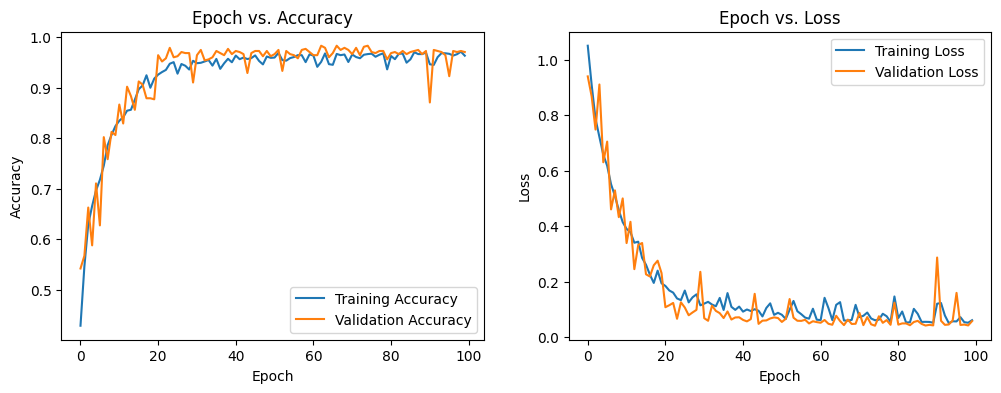

In [ ]:

#Plot epoch vs Accuracy and epoch vs Loss
accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(range(epochs), accuracy, label='Training Accuracy')
plt.plot(range(epochs), val_accuracy, label='Validation Accuracy')
plt.title('Epoch vs. Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.title('Epoch vs. Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
scores1 = model1.evaluate(test_ds)
print(scores1)
acc = history1.history['accuracy']
print(acc)
val_acc = history1.history['val_accuracy']
print(val_acc)
loss = history1.history['loss']
print(loss)
val_loss = history1.history['val_loss']
print(val_loss)

29/29 [==============================] - 44s 79ms/step - loss: 0.0617 - accuracy: 0.9741
[0.06170257553458214, 0.9741379022598267]
[0.42819148302078247, 0.5454787015914917, 0.6289893388748169, 0.6656914949417114, 0.6962766051292419, 0.7175531983375549, 0.7454787492752075, 0.7861701846122742, 0.8066489100456238, 0.8239361643791199, 0.8345744609832764, 0.8414893746376038, 0.8545212745666504, 0.8563829660415649, 0.876329779624939, 0.8970744609832764, 0.9045212864875793, 0.9247340559959412, 0.8999999761581421, 0.9180850982666016, 0.9260638356208801, 0.9311169981956482, 0.9353723526000977, 0.9476063847541809, 0.9507978558540344, 0.9279255270957947, 0.9470744729042053, 0.943617045879364, 0.936170220375061, 0.9534574747085571, 0.9486702084541321, 0.9494680762290955, 0.9521276354789734, 0.9550532102584839, 0.9438830018043518, 0.9571808576583862, 0.9375, 0.9484042525291443, 0.957446813583374, 0.9505318999290466, 0.9638298153877258, 0.9566489458084106, 0.9598404169082642, 0.9569149017333984, 0.9

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 27ms/step


ValueError: num must be an integer with 1 <= num <= 9, not 10

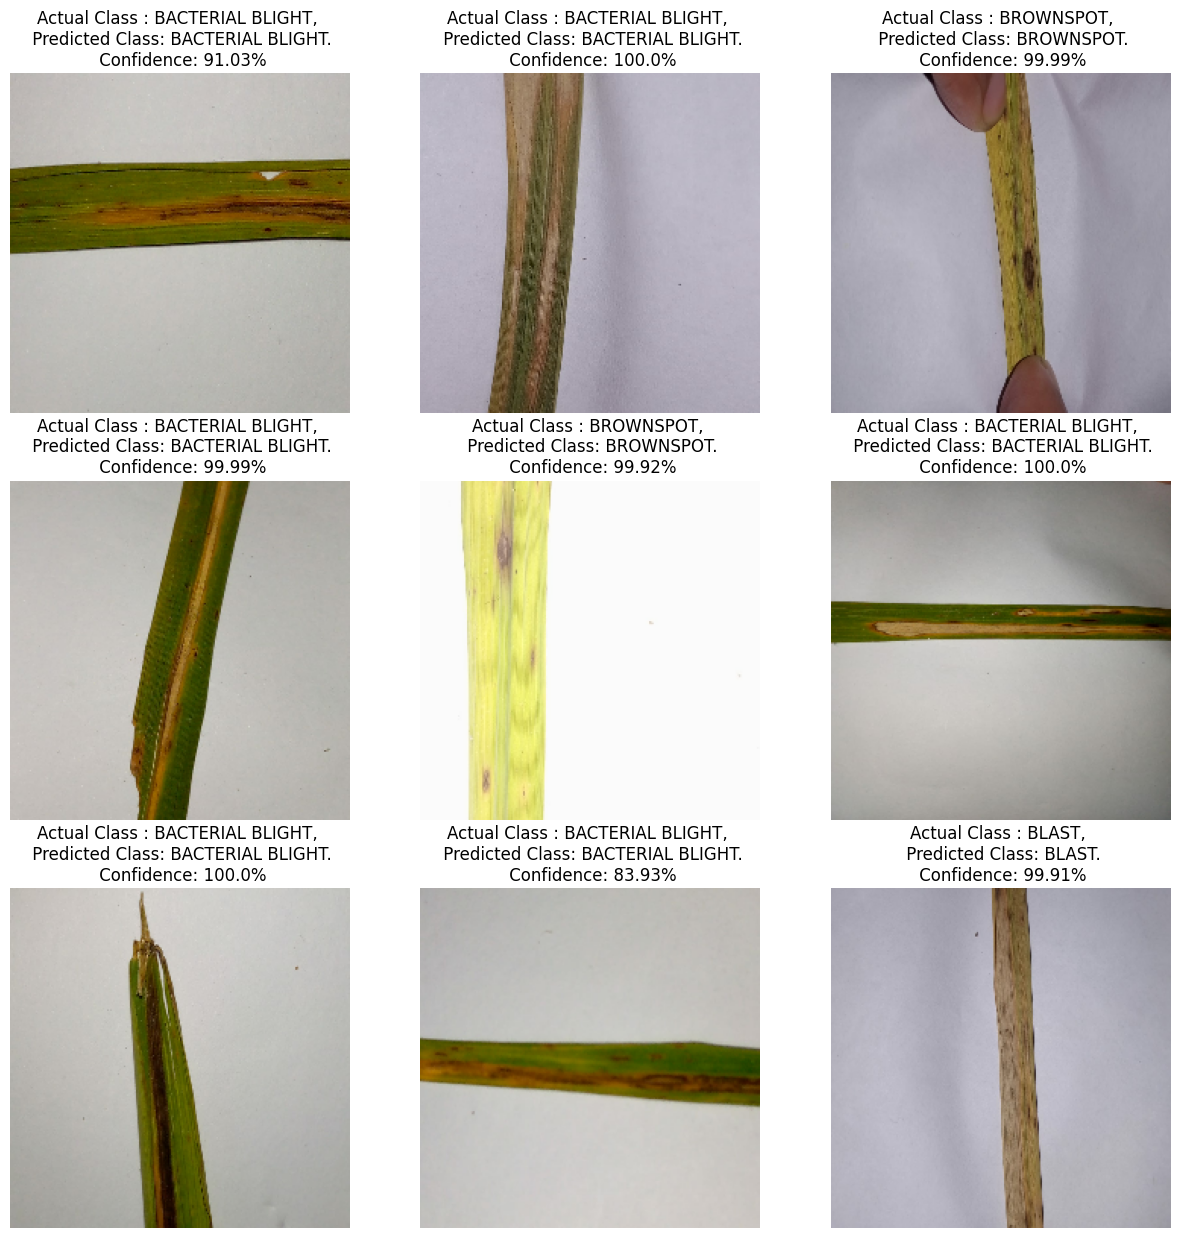

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model1, images[i].numpy())

        actual_class = class_names[labels[i]]

        plt.title(f"Actual Class : {actual_class}, \n Predicted Class: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

for image_batch, label_batch in test_ds:
  y_true.append(label_batch)
  preds = model1.predict(image_batch)
  y_pred.append(np.argmax(preds, axis=-1))

correct_labels = tf.concat([item for item in y_true], axis=0)
predicted_labels = tf.concat([item for item in y_pred], axis=0)
conf_matrix = confusion_matrix(correct_labels, predicted_labels)

1/1 [==============================] - 0s 25ms/step


In [ ]:
print(classification_report( correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       162
           1       1.00      0.96      0.98       139
           2       0.96      0.98      0.97       163

    accuracy                           0.97       464
   macro avg       0.98      0.97      0.97       464
weighted avg       0.97      0.97      0.97       464



In [ ]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc


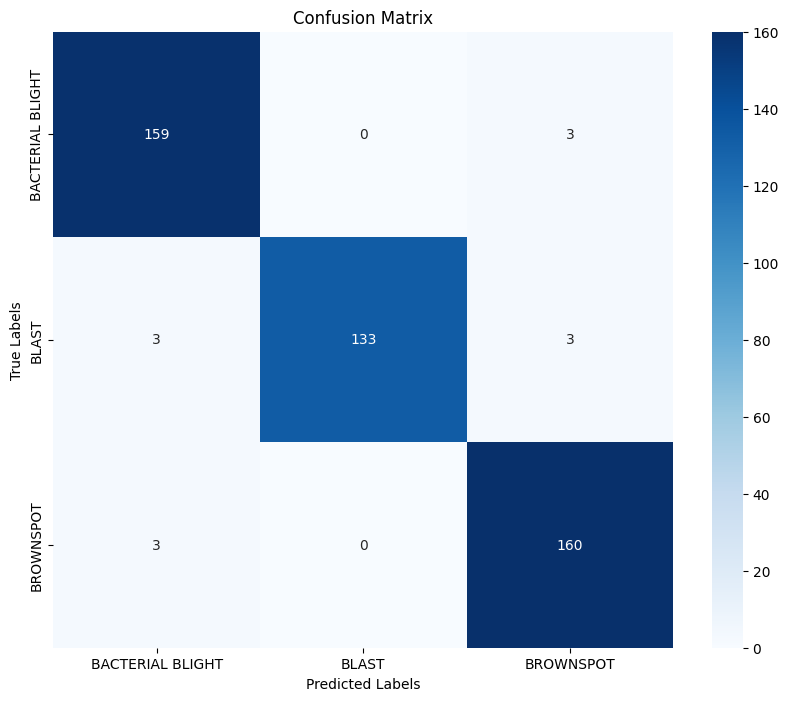

In [ ]:

conf_mat = confusion_matrix(correct_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print("Mean Absolute Error:" , mean_absolute_error(correct_labels,predicted_labels))

Mean Absolute Error: 0.03879310344827586


In [ ]:
print("Mean Squared Error:" , mean_squared_error(correct_labels,predicted_labels))

Mean Squared Error: 0.06465517241379311


29/29 [==============================] - 2s 79ms/step


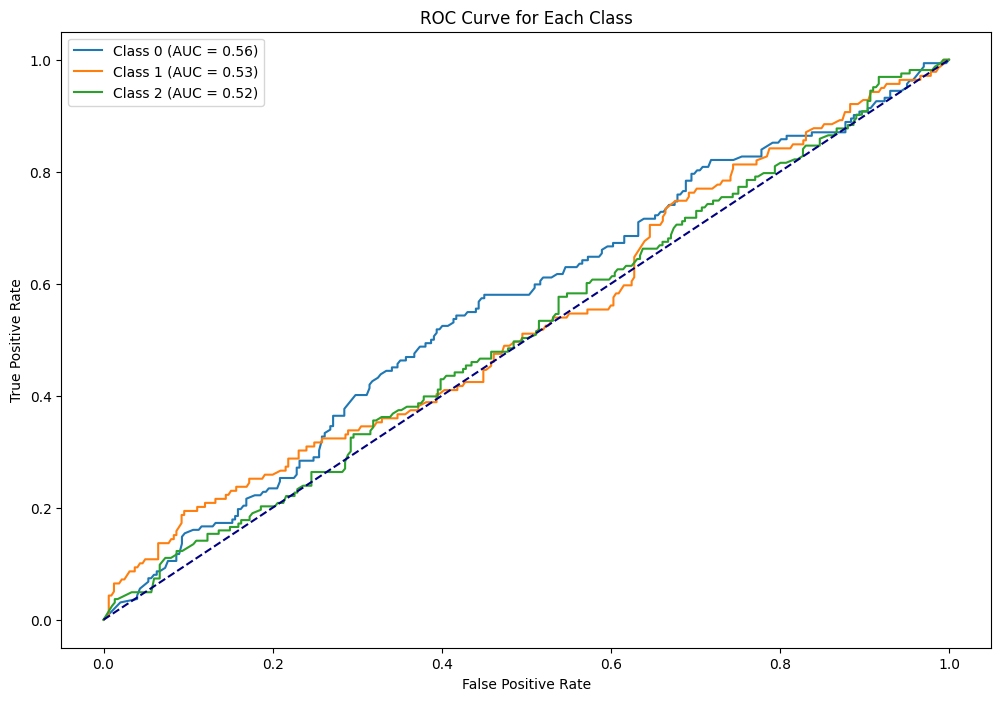

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# ...

# Get predicted probabilities for each class
y_prob = model1.predict(test_ds)

# Convert true labels to one-hot encoding
y_true_one_hot = tf.keras.utils.to_categorical(correct_labels, num_classes=num_classes)

# Calculate AUC for each class
auc_scores = []
for i in range(num_classes):
    auc_score = roc_auc_score(y_true_one_hot[:, i], y_prob[:, i])
    auc_scores.append(auc_score)

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# ...

# Get predicted probabilities for each class
y_prob = model1.predict(test_ds)

# Convert true labels to one-hot encoding
y_true_one_hot = tf.keras.utils.to_categorical(correct_labels, num_classes=num_classes)

# Calculate micro-average AUC score
micro_auc_score = roc_auc_score(y_true_one_hot, y_prob, average='micro')

# Calculate macro-average AUC score
macro_auc_score = roc_auc_score(y_true_one_hot, y_prob, average='macro')

print(f'Micro-average AUC Score: {micro_auc_score:.4f}')
print(f'Macro-average AUC Score: {macro_auc_score:.4f}')


29/29 [==============================] - 2s 77ms/step
Micro-average AUC Score: 0.5053
Macro-average AUC Score: 0.5051
